In [271]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

In [2]:
from collections import Counter
import requests

with requests.get(
    "https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs/export?format=csv") as r, open("features.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

with requests.get(
    "https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs/export?format=csv") as r, open("target.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

In [272]:
df_features = pd.read_csv("features.csv")

df_target = pd.read_csv("target.csv")

/usr/local/Cellar/jupyterlab/3.1.9/libexec/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [273]:
df = df_features.merge(df_target, left_on='id', right_on='id')

In [274]:
df.head()

,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_al_dia_siguiente
0,Retiro,2016-10-11,Este,Nornoreste,10.7,59.0,56.0,86942,no,16.0,...,1010.2,Estesureste,33.0,29.2,16.8,24.1,25.3,19.0,4.0,no
1,Vélez Sársfield,2016-03-28,Sur,suroeste,0.0,49.0,83.0,102098,no,2.6,...,1021.4,Sur,31.0,16.9,10.6,16.4,12.3,13.0,7.0,no
2,Palermo,2017-05-11,Sursureste,Norte,4.3,59.0,83.0,67154,no,2.4,...,1026.5,Norte,26.0,16.6,4.4,15.7,9.4,9.0,13.0,no
3,Mataderos,2012-05-07,suroeste,Sur,NaN,67.0,93.0,50245,no,NaN,...,1020.0,Oestesuroeste,13.0,11.4,0.8,11.1,4.0,6.0,6.0,no
4,Recoleta,2014-06-19,Nornoreste,Nornoreste,0.8,94.0,97.0,82904,no,0.8,...,1021.9,Nornoreste,33.0,11.6,6.7,11.2,8.8,11.0,15.0,no


In [275]:
df.isnull()


,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_al_dia_siguiente
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116363,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
116364,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
116365,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
116366,False,False,False,True,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [276]:
df.dtypes

barrio                                      object
dia                                         object
direccion_viento_tarde                      object
direccion_viento_temprano                   object
horas_de_sol                               float64
humedad_tarde                              float64
humedad_temprano                           float64
id                                           int64
llovieron_hamburguesas_hoy                  object
mm_evaporados_agua                         float64
mm_lluvia_dia                              float64
nubosidad_tarde                            float64
nubosidad_temprano                         float64
presion_atmosferica_tarde                   object
presion_atmosferica_temprano               float64
rafaga_viento_max_direccion                 object
rafaga_viento_max_velocidad                float64
temp_max                                   float64
temp_min                                   float64
temperatura_tarde              

In [277]:
df['presion_atmosferica_tarde'] = pd.to_numeric(df['presion_atmosferica_tarde'],errors='coerce')

In [278]:
df = df.dropna(subset=['llovieron_hamburguesas_al_dia_siguiente'])

In [279]:
df['dia'] = pd.to_datetime(df['dia'])

In [280]:
df[df['barrio'] == 'Palermo cheto'].value_counts(dropna=False)

barrio         dia         direccion_viento_tarde  direccion_viento_temprano  horas_de_sol  humedad_tarde  humedad_temprano  id      llovieron_hamburguesas_hoy  mm_evaporados_agua  mm_lluvia_dia  nubosidad_tarde  nubosidad_temprano  presion_atmosferica_tarde  presion_atmosferica_temprano  rafaga_viento_max_direccion  rafaga_viento_max_velocidad  temp_max  temp_min  temperatura_tarde  temperatura_temprano  velocidad_viendo_tarde  velocidad_viendo_temprano  llovieron_hamburguesas_al_dia_siguiente
Palermo cheto  2013-03-01  Este                    Este                       NaN           54.0           76.0              143882  no                          NaN                 0.8            NaN              NaN                 1007.5                     1010.6                        Estesureste                  48.0                         30.0      19.7      28.4               21.7                  24.0                    30.0                       no                                      

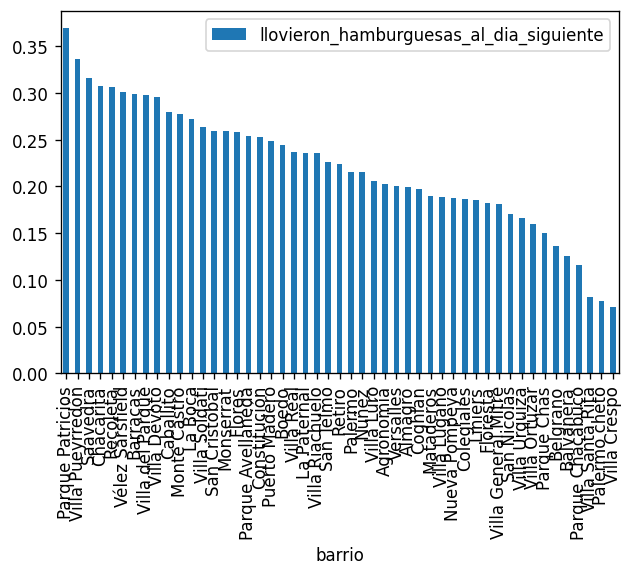

In [10]:
plt.rcParams["figure.dpi"] = 120
lluvia_por_barrios = df[['barrio', 'llovieron_hamburguesas_al_dia_siguiente']][df['llovieron_hamburguesas_al_dia_siguiente']=='si'].groupby('barrio').count()

lluvia_por_barrios /=  df[['barrio', 'llovieron_hamburguesas_al_dia_siguiente']].groupby('barrio').count()

lluvia_por_barrios.sort_values(by = 'llovieron_hamburguesas_al_dia_siguiente', ascending=False).plot(kind = 'bar')

plt.show()

In [11]:
df['llovieron_hamburguesas_al_dia_siguiente'].value_counts(dropna=False, normalize = True)


no     0.758645
si     0.218677
NaN    0.022678
Name: llovieron_hamburguesas_al_dia_siguiente, dtype: float64

In [12]:
(df['llovieron_hamburguesas_hoy'] == df['llovieron_hamburguesas_al_dia_siguiente']).mean()

0.7380293551491819

In [13]:
columnas_con_numeros = ['horas_de_sol', 'humedad_tarde', 'humedad_temprano', 'id', 'mm_evaporados_agua', 'mm_lluvia_dia', 'nubosidad_tarde', 'nubosidad_temprano', 'presion_atmosferica_temprano', 'presion_atmosferica_tarde', 'rafaga_viento_max_velocidad', 'temp_max', 'temp_min', 'temperatura_tarde', 'temperatura_temprano', 'velocidad_viendo_tarde', 'velocidad_viendo_temprano']

(df[columnas_con_numeros] < 0).any().to_frame('Valores negativos?')

,Valores negativos?
horas_de_sol,False
humedad_tarde,False
humedad_temprano,False
id,False
mm_evaporados_agua,False
mm_lluvia_dia,False
nubosidad_tarde,False
nubosidad_temprano,False
presion_atmosferica_temprano,False
presion_atmosferica_tarde,False


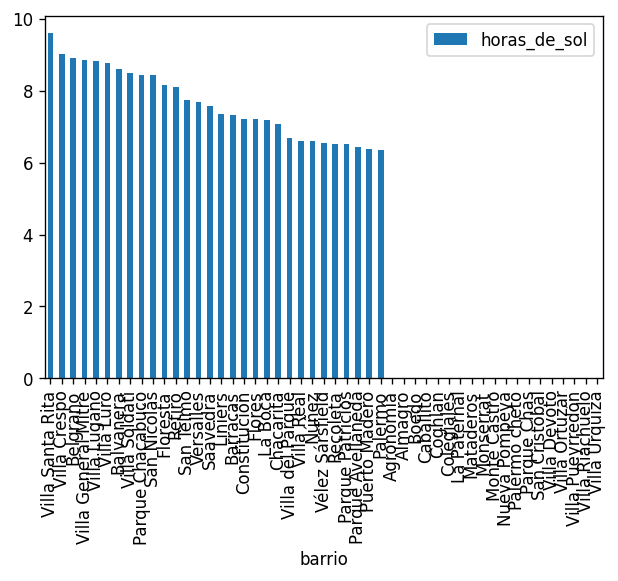

In [14]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'horas_de_sol']].groupby('barrio').mean().sort_values(by = 'horas_de_sol', ascending=False).plot(kind = 'bar')

plt.show()

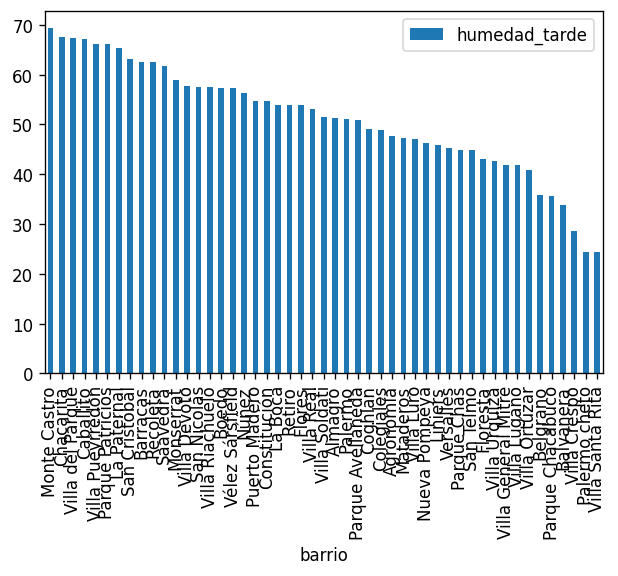

In [15]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'humedad_tarde']].groupby('barrio').mean().sort_values(by = 'humedad_tarde', ascending=False).plot(kind = 'bar')

plt.show()

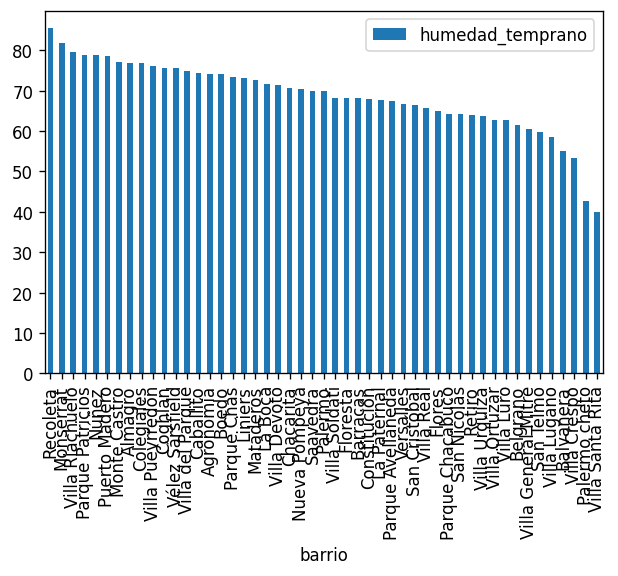

In [16]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'humedad_temprano']].groupby('barrio').mean().sort_values(by = 'humedad_temprano', ascending=False).plot(kind = 'bar')

plt.show()

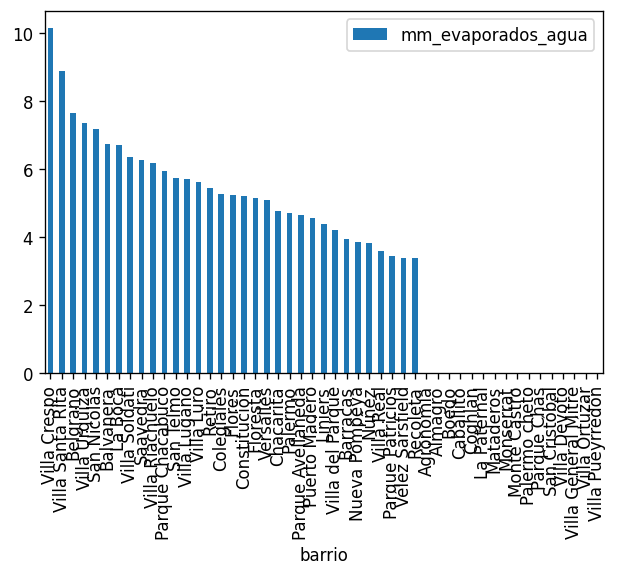

In [17]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'mm_evaporados_agua']].groupby('barrio').mean().sort_values(by = 'mm_evaporados_agua', ascending=False).plot(kind = 'bar')

plt.show()

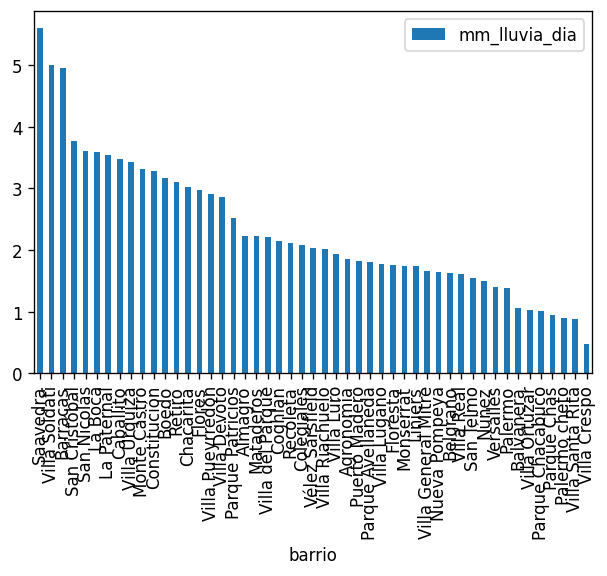

In [18]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'mm_lluvia_dia']].groupby('barrio').mean().sort_values(by = 'mm_lluvia_dia', ascending=False).plot(kind = 'bar')

plt.show()

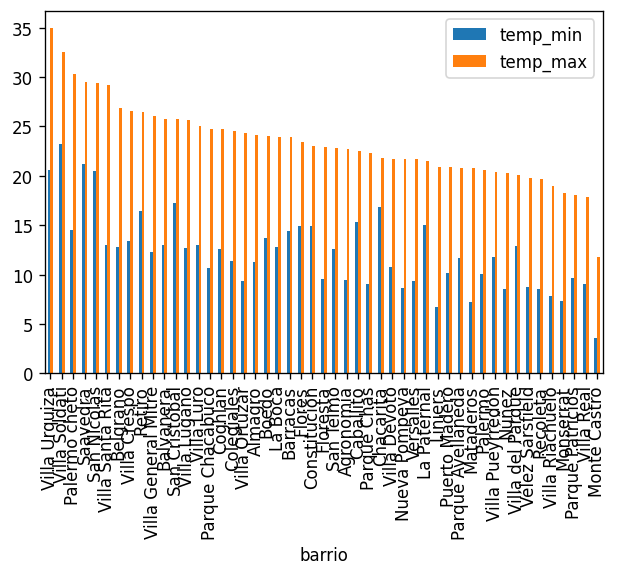

In [19]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'temp_min', 'temp_max']].groupby('barrio').mean().sort_values(by = 'temp_max', ascending=False).plot(kind = 'bar')

plt.show()

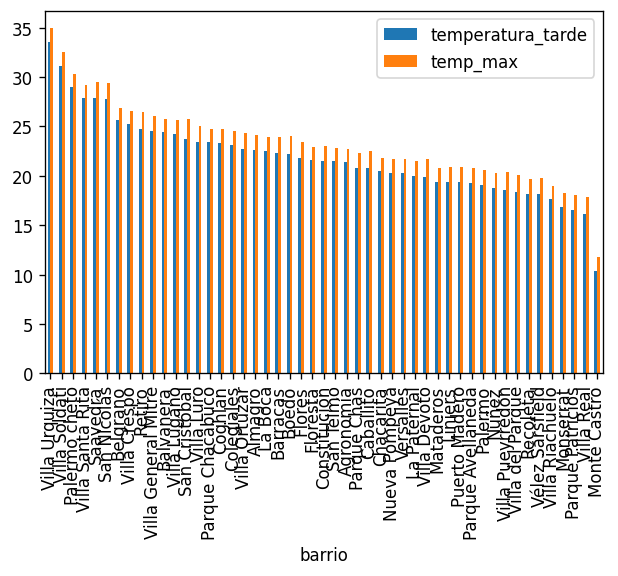

In [20]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'temperatura_tarde', 'temp_max']].groupby('barrio').mean().sort_values(by = 'temperatura_tarde', ascending=False).plot(kind = 'bar')

plt.show()

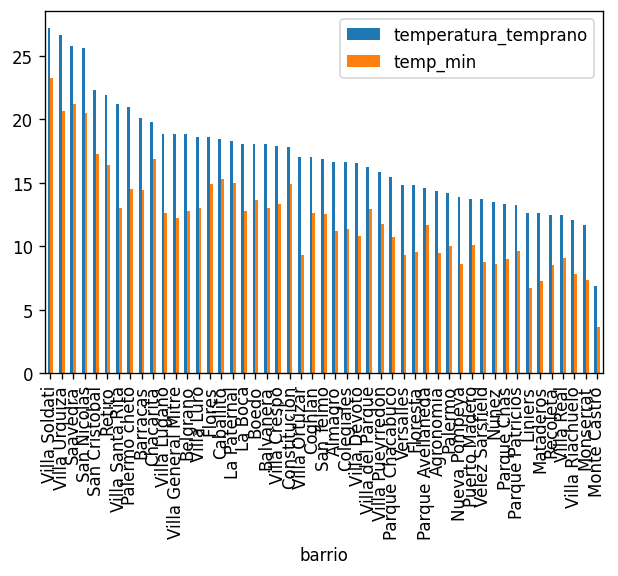

In [21]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'temperatura_temprano', 'temp_min']].groupby('barrio').mean().sort_values(by = 'temperatura_temprano', ascending=False).plot(kind = 'bar')

plt.show()

<AxesSubplot:xlabel='temp_max', ylabel='temperatura_tarde'>

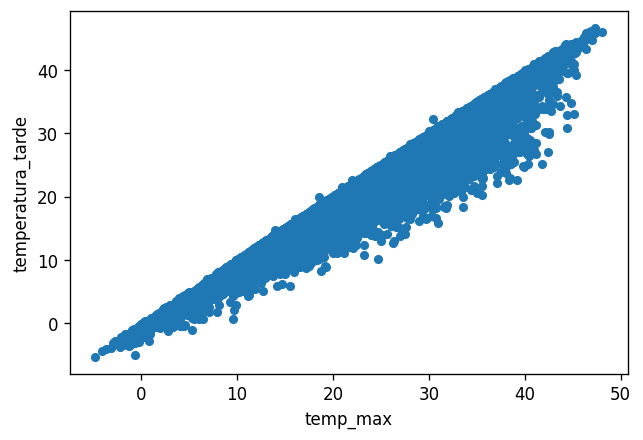

In [22]:
df.plot(
    x='temp_max',
    y='temperatura_tarde',
    kind='scatter',
)

<AxesSubplot:xlabel='temp_min', ylabel='temperatura_temprano'>

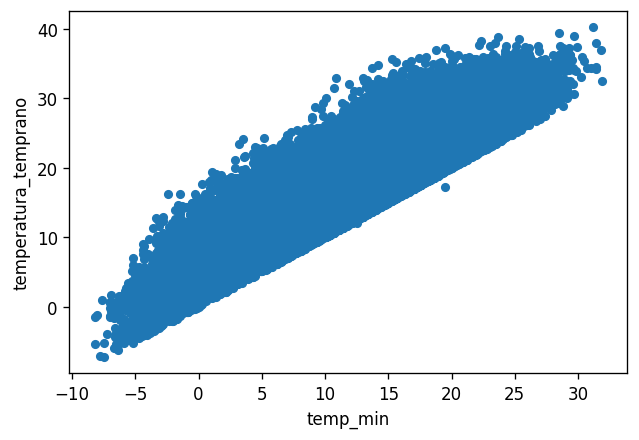

In [23]:
df.plot(
    x='temp_min',
    y='temperatura_temprano',
    kind='scatter',
)

<AxesSubplot:xlabel='temp_max', ylabel='temp_min'>

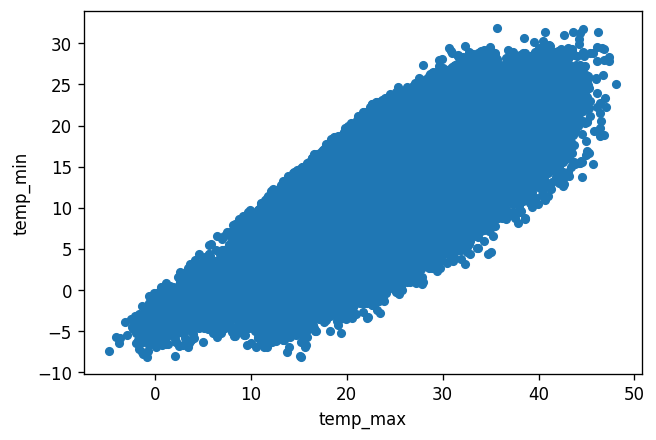

In [24]:
df.plot(
    x='temp_max',
    y='temp_min',
    kind='scatter',
)

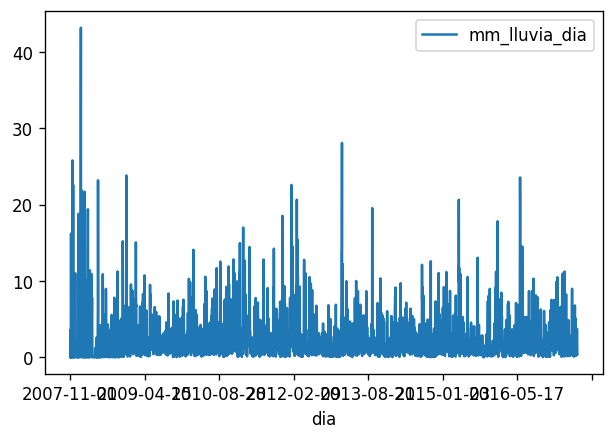

In [25]:
plt.rcParams["figure.dpi"] = 120

df[['dia', 'mm_lluvia_dia']].groupby('dia').mean().plot(kind='line')
plt.show()

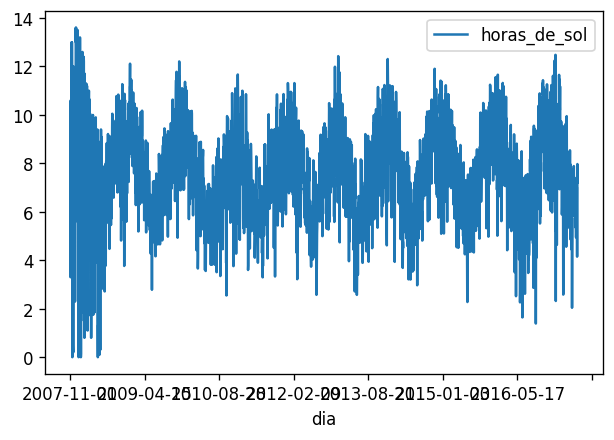

In [26]:
plt.rcParams["figure.dpi"] = 120

df[['dia', 'horas_de_sol']].groupby('dia').mean().plot(kind='line')
plt.show()

In [27]:
df_target_mean = df.groupby('llovieron_hamburguesas_al_dia_siguiente').mean().transpose().drop(['id', 'presion_atmosferica_temprano'])
df_target_mean_normalized = df_target_mean.div(df_target_mean.sum(axis=1), axis=0)
df_target_mean_normalized = df_target_mean_normalized.sort_values(by = 'si', ascending=False)

<AxesSubplot:>

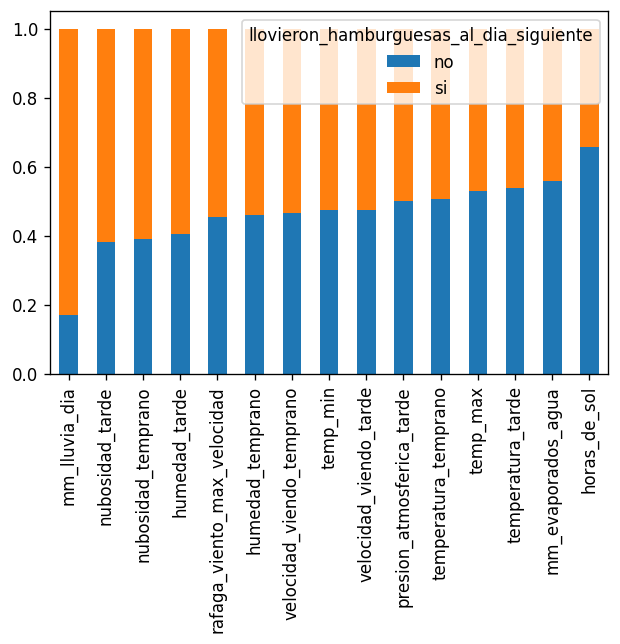

In [28]:
df_target_mean_normalized.plot(kind='bar', stacked=True)

<AxesSubplot:ylabel='Density'>

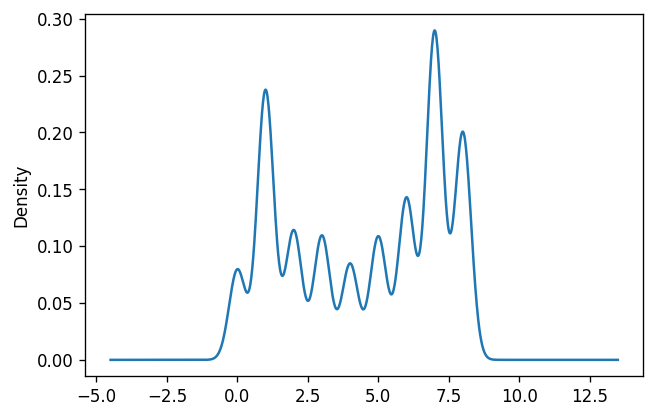

In [29]:
df['nubosidad_tarde'].plot(kind='density')

<AxesSubplot:>

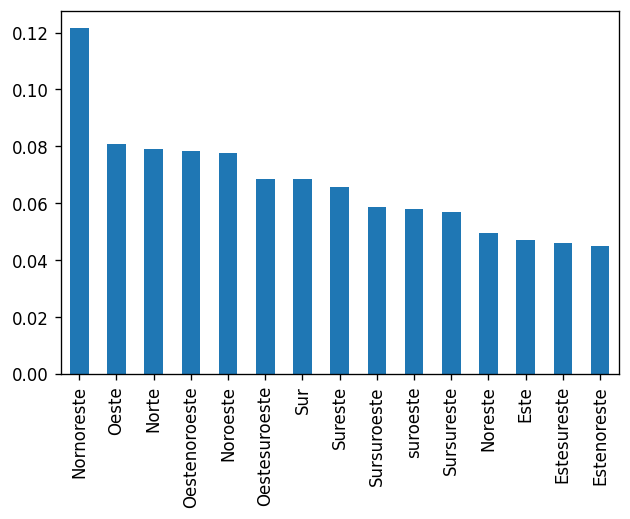

In [30]:
(df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si']['direccion_viento_tarde']).value_counts(normalize = True).sort_values(ascending=False).plot(kind='bar')



<AxesSubplot:ylabel='Density'>

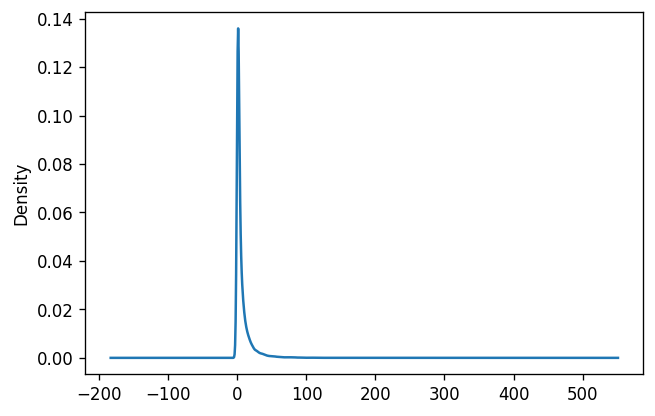

In [31]:
df[df['mm_lluvia_dia']>0]['mm_lluvia_dia'].plot(kind='density')

In [32]:
df.shape

(116368, 24)

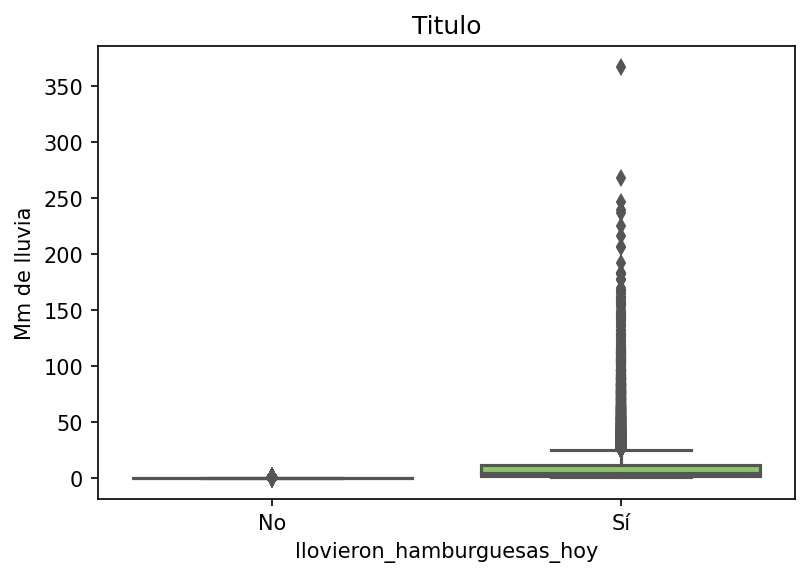

In [33]:
import seaborn as sns

plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='mm_lluvia_dia',
    x='llovieron_hamburguesas_hoy',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Mm de lluvia")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

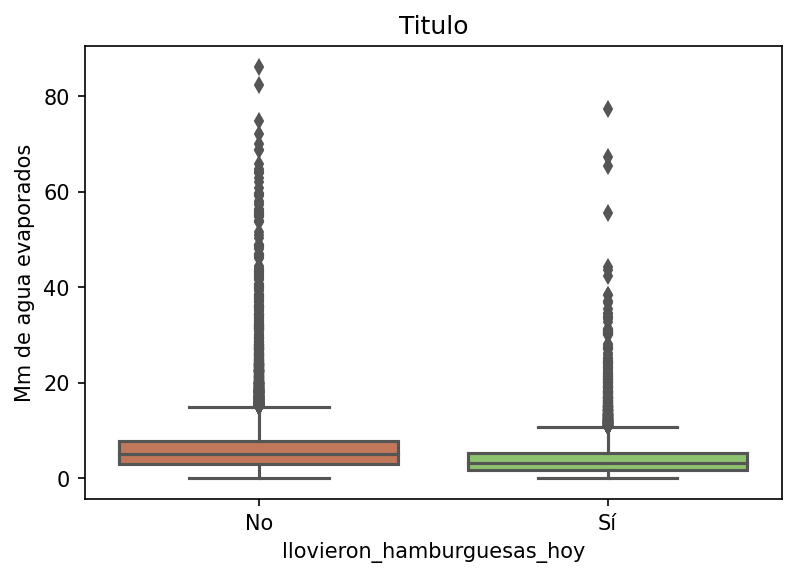

In [34]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='mm_evaporados_agua',
    x='llovieron_hamburguesas_hoy',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Mm de agua evaporados")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

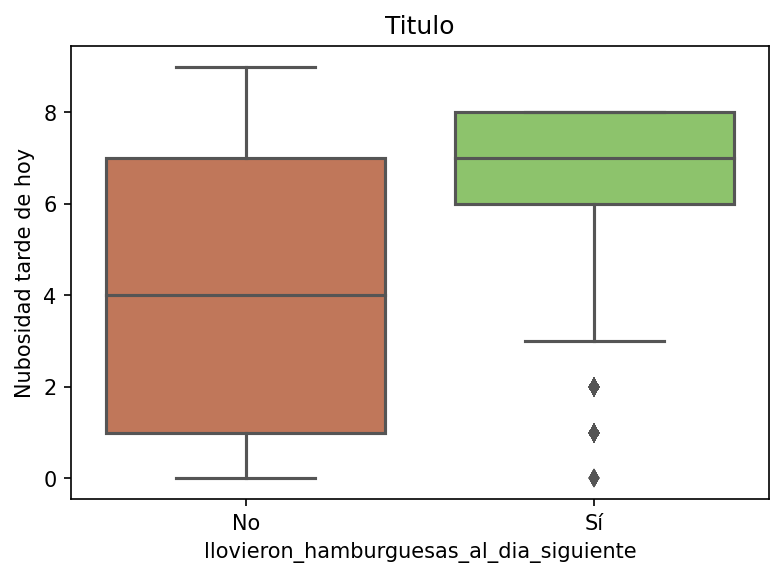

In [35]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='nubosidad_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Nubosidad tarde de hoy")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

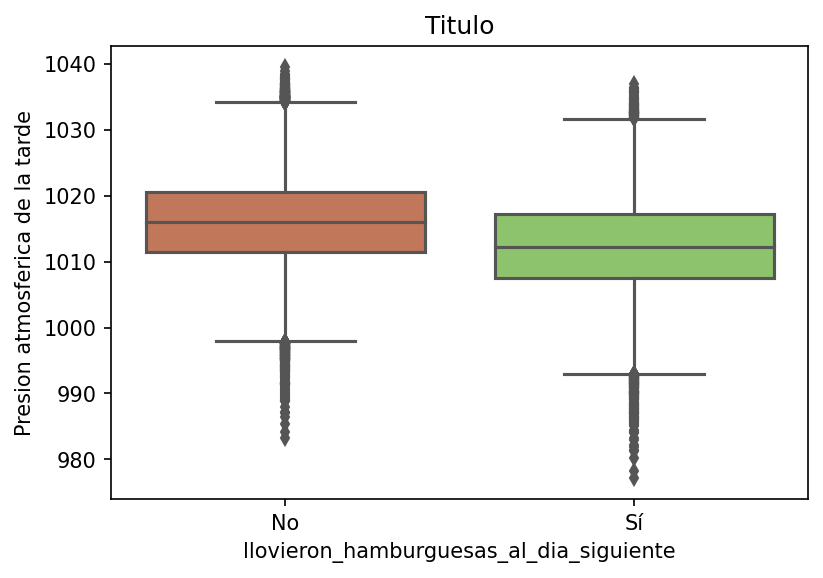

In [36]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='presion_atmosferica_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Presion atmosferica de la tarde")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

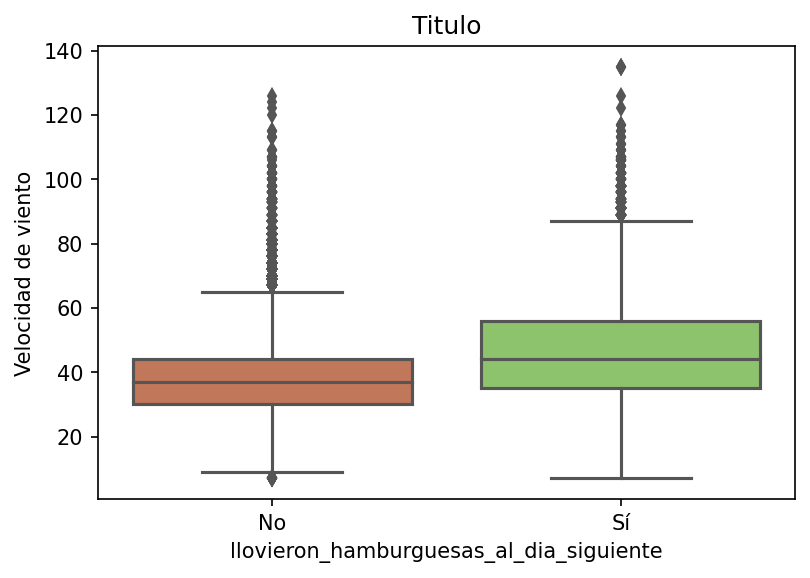

In [37]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='rafaga_viento_max_velocidad',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Velocidad de viento")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

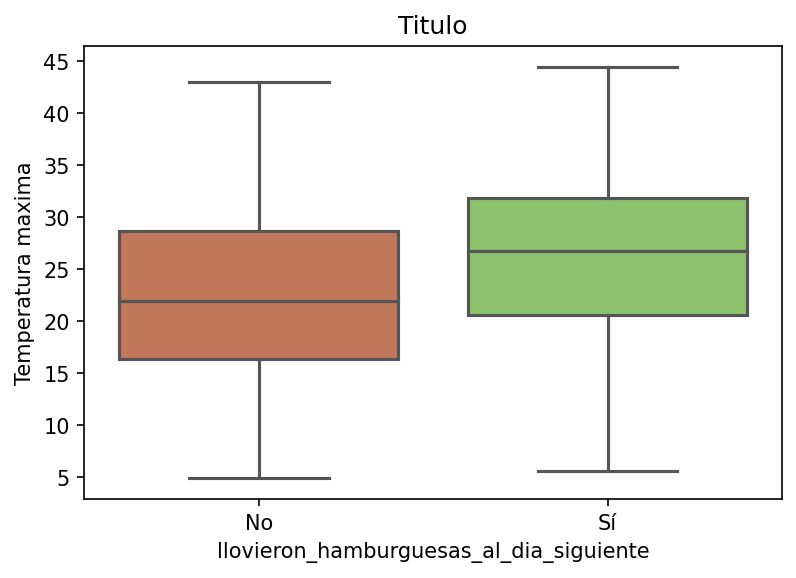

In [38]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df[(df['presion_atmosferica_tarde']<1013) & (df['nubosidad_tarde'] > 6)],
       
    y='temp_max',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Temperatura maxima")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

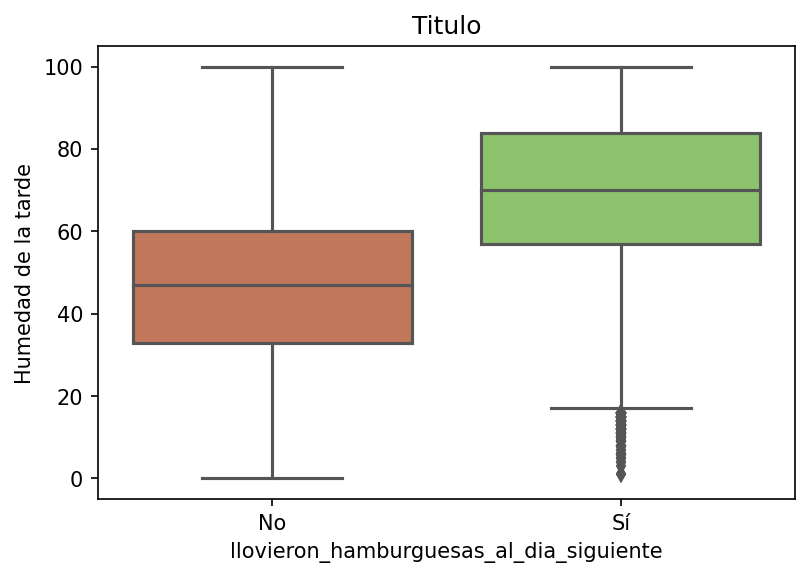

In [39]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
    y='humedad_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Humedad de la tarde")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

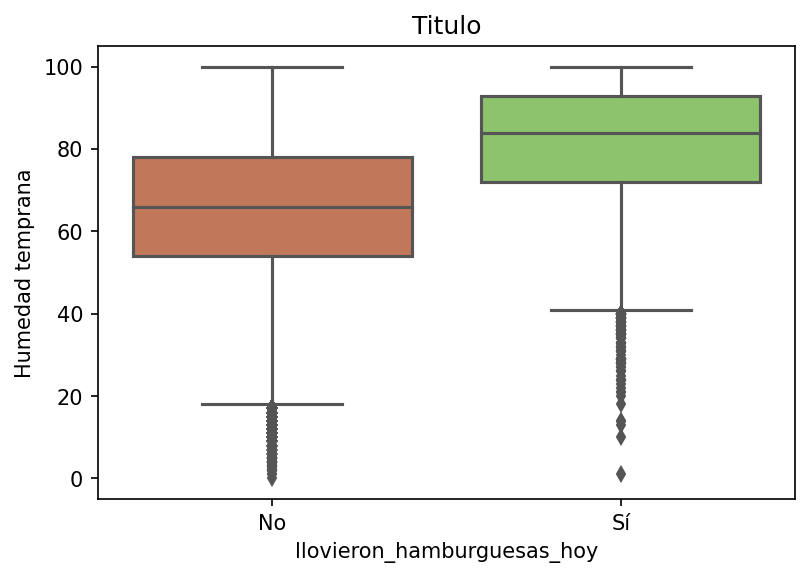

In [42]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
    y='humedad_temprano',
    x='llovieron_hamburguesas_hoy',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Humedad temprana")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

In [86]:
df_no = df[df['llovieron_hamburguesas_hoy'] == 'no']
df_no_si = df[(df['llovieron_hamburguesas_hoy'] == 'no') & (df['llovieron_hamburguesas_al_dia_siguiente'] == 'si')]

<AxesSubplot:>

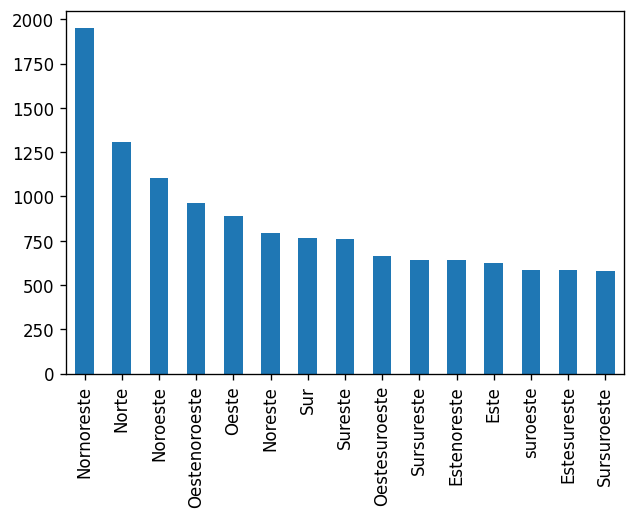

In [87]:
df_no_si['direccion_viento_tarde'].value_counts().plot(kind='bar')

<AxesSubplot:>

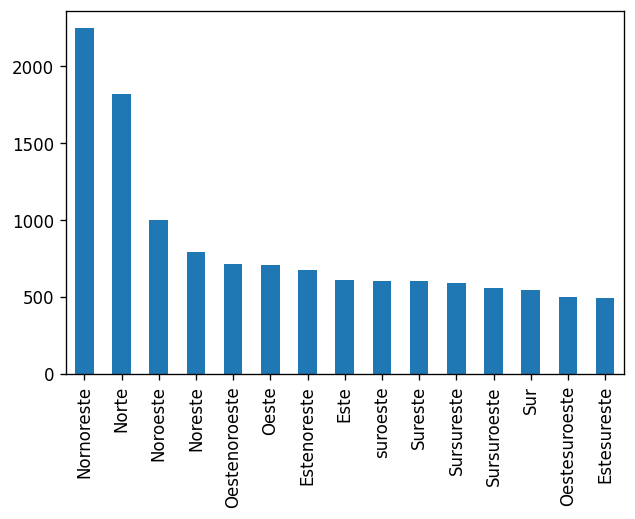

In [88]:
df_no_si['direccion_viento_temprano'].value_counts().plot(kind='bar')

<AxesSubplot:>

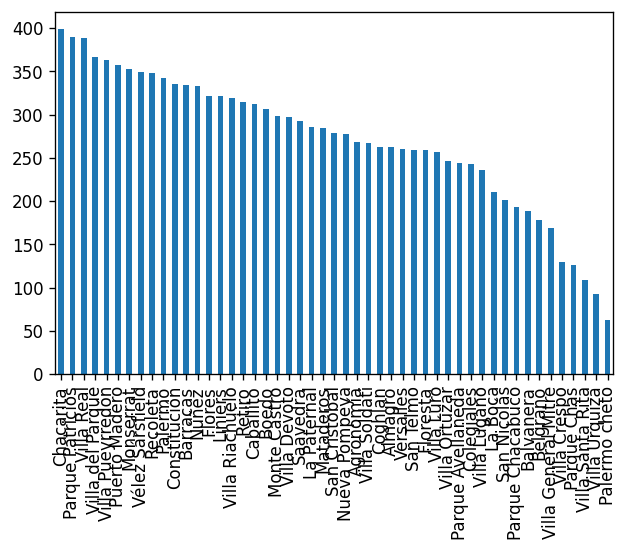

In [89]:
df_no_si['barrio'].value_counts().plot(kind='bar')

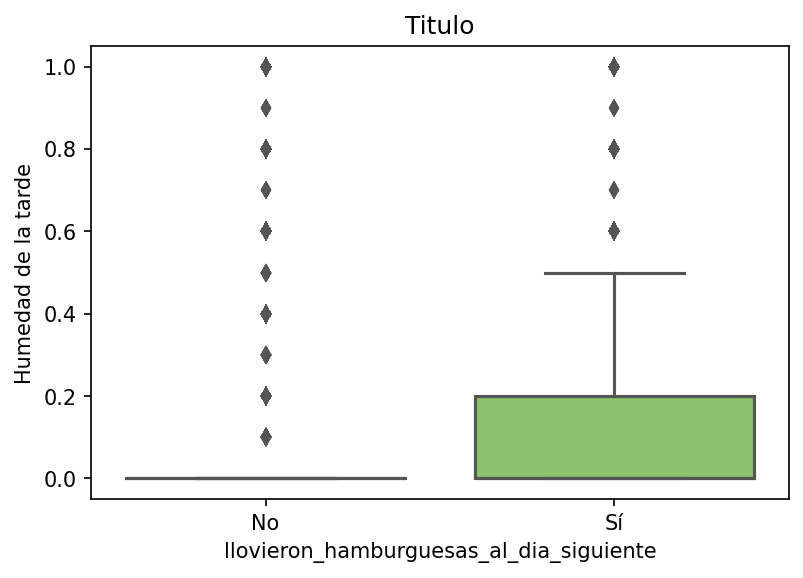

In [96]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df_no,
    y='mm_lluvia_dia',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Humedad de la tarde")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

<AxesSubplot:ylabel='Density'>

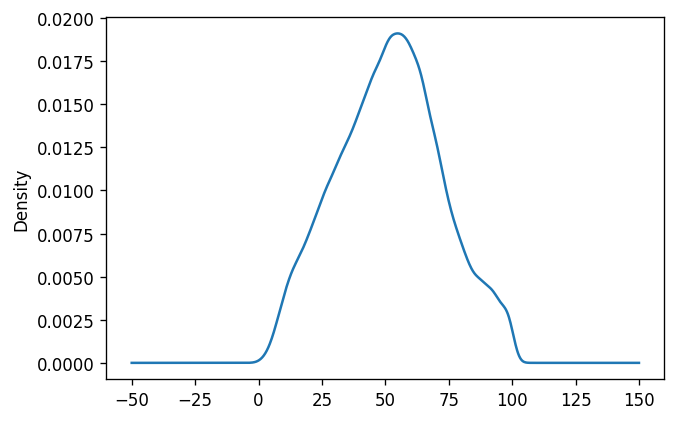

In [85]:
df['humedad_tarde'].plot(kind='density')

<AxesSubplot:>

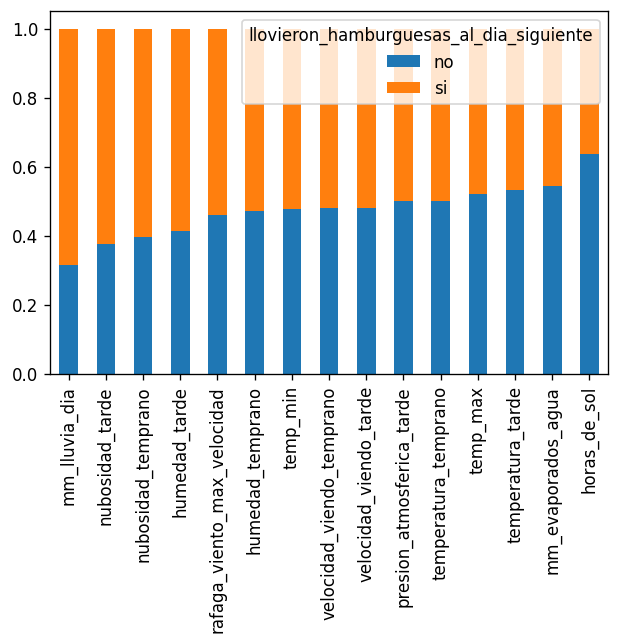

In [99]:
df_no_target_mean = df_no.groupby('llovieron_hamburguesas_al_dia_siguiente').mean().transpose().drop(['id', 'presion_atmosferica_temprano'])
df_no_target_mean_normalized = df_no_target_mean.div(df_no_target_mean.sum(axis=1), axis=0)
df_no_target_mean_normalized = df_no_target_mean_normalized.sort_values(by = 'si', ascending=False)
df_no_target_mean_normalized.plot(kind='bar', stacked=True)

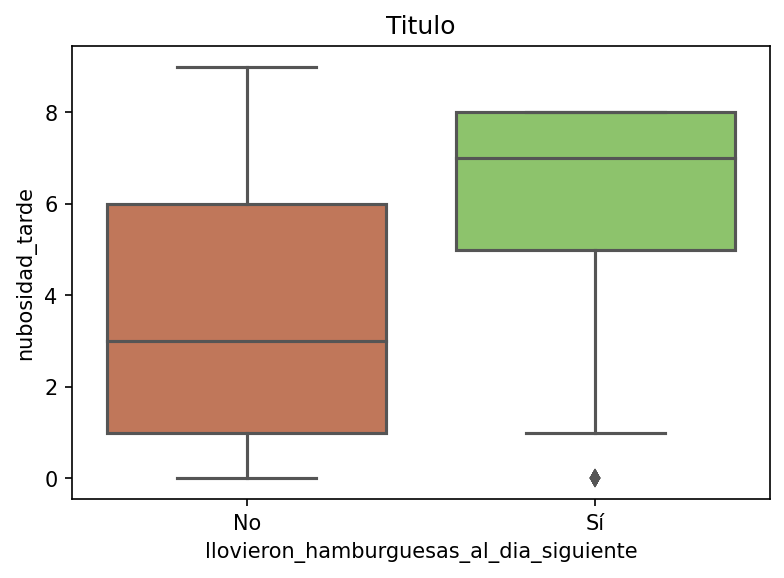

In [120]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df_no,
    y='nubosidad_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xticks([False, True], ["No", "Sí"])
plt.show()

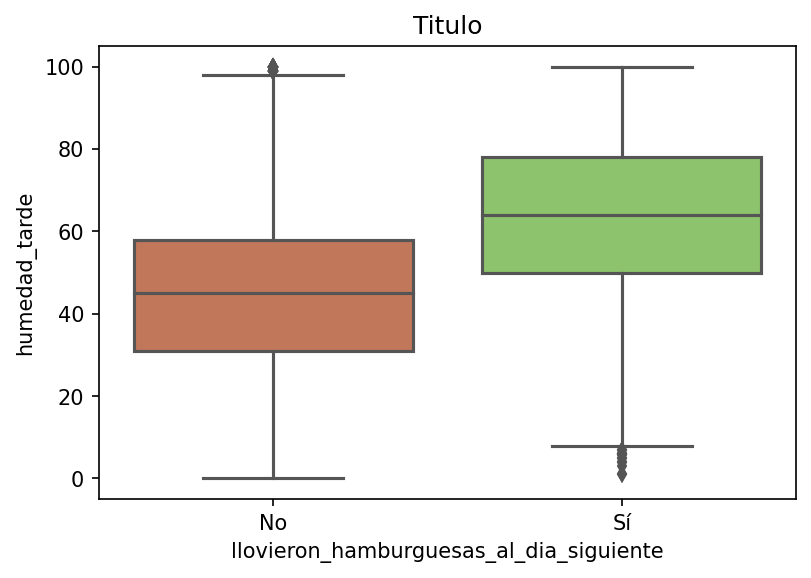

In [133]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df_no,
    y='humedad_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xticks([False, True], ["No", "Sí"])
plt.show()

<AxesSubplot:xlabel='direccion_viento_tarde', ylabel='barrio'>

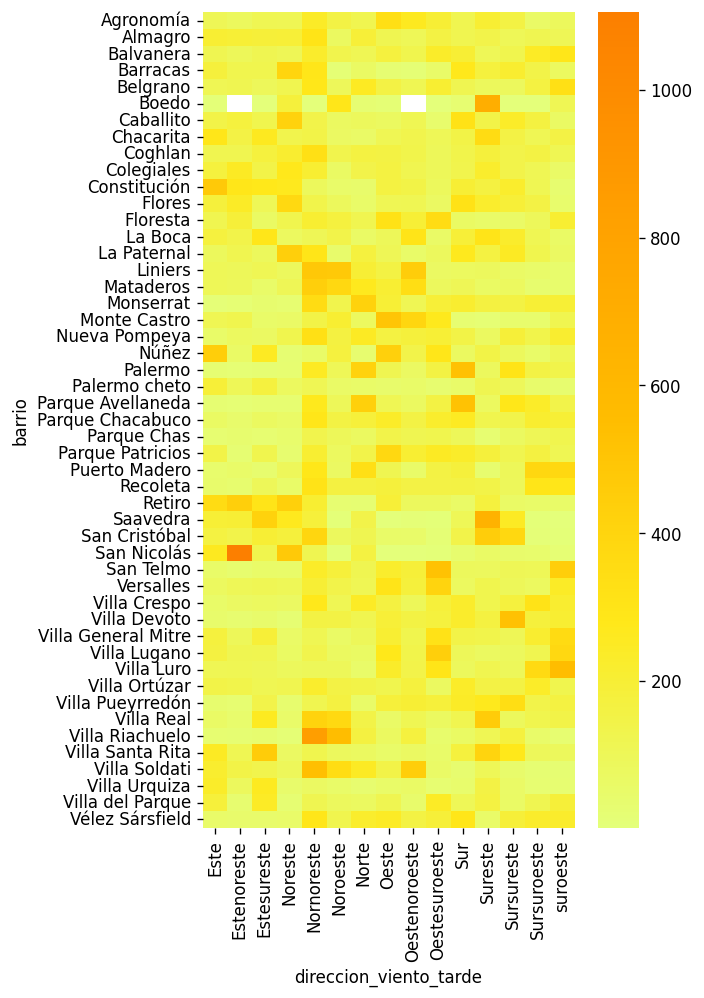

In [223]:

plt.figure(figsize=(5, 9))
sns.heatmap(pd.pivot_table(df, index='barrio', columns='direccion_viento_tarde', aggfunc='size'), xticklabels=True, yticklabels=True, cmap='Wistia')



In [207]:
pd.pivot_table(df, index='barrio', columns='direccion_viento_tarde', aggfunc='size')

direccion_viento_tarde,Este,Estenoreste,Estesureste,Noreste,Nornoreste,Noroeste,Norte,Oeste,Oestenoroeste,Oestesuroeste,Sur,Sureste,Sursureste,Sursuroeste,suroeste
barrio,,,,,,,,,,,,,,,
Agronomía,105.0,86.0,114.0,110.0,240.0,152.0,124.0,336.0,262.0,202.0,122.0,206.0,158.0,59.0,89.0
Almagro,204.0,199.0,190.0,193.0,307.0,77.0,191.0,118.0,101.0,158.0,122.0,140.0,104.0,120.0,107.0
Balvanera,120.0,99.0,121.0,106.0,226.0,132.0,111.0,173.0,128.0,230.0,200.0,101.0,127.0,243.0,294.0
Barracas,178.0,127.0,130.0,401.0,290.0,15.0,67.0,23.0,17.0,53.0,273.0,176.0,215.0,145.0,79.0
Belgrano,113.0,121.0,95.0,124.0,283.0,95.0,254.0,152.0,114.0,210.0,121.0,89.0,87.0,161.0,325.0
Boedo,7.0,NaN,2.0,179.0,3.0,288.0,26.0,16.0,NaN,3.0,29.0,697.0,2.0,1.0,111.0
Caballito,147.0,177.0,129.0,416.0,140.0,77.0,89.0,78.0,116.0,42.0,316.0,147.0,236.0,169.0,66.0
Chacarita,289.0,152.0,262.0,133.0,145.0,72.0,60.0,111.0,132.0,103.0,151.0,356.0,154.0,110.0,154.0
Coghlan,123.0,125.0,175.0,215.0,328.0,134.0,163.0,157.0,137.0,100.0,136.0,179.0,142.0,157.0,114.0


In [249]:
pd.pivot_table(df, index='barrio', columns='llovieron_hamburguesas_al_dia_siguiente', aggfunc='size')

llovieron_hamburguesas_al_dia_siguiente,no,si
barrio,,
Agronomía,1895,482
Almagro,1865,465
Balvanera,2101,301
Barracas,1671,713
Belgrano,1956,310
Boedo,1780,575
Caballito,1676,652
Chacarita,1626,722
Coghlan,1912,471


<AxesSubplot:xlabel='mes'>

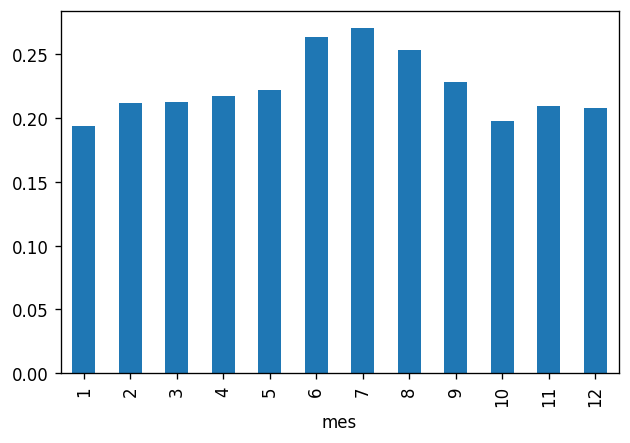

In [290]:
((df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si'].groupby(df['dia'].dt.month).size())/(df.groupby(df['dia'].dt.month).size())).plot(kind='bar', xlabel='mes')




<AxesSubplot:xlabel='año'>

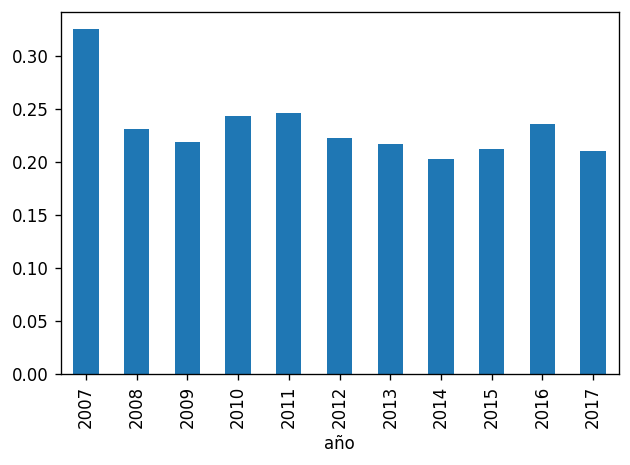

In [291]:
((df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si'].groupby(df['dia'].dt.year).size())/(df.groupby(df['dia'].dt.year).size())).plot(kind='bar', xlabel='año')


<AxesSubplot:xlabel='mes', ylabel='año'>

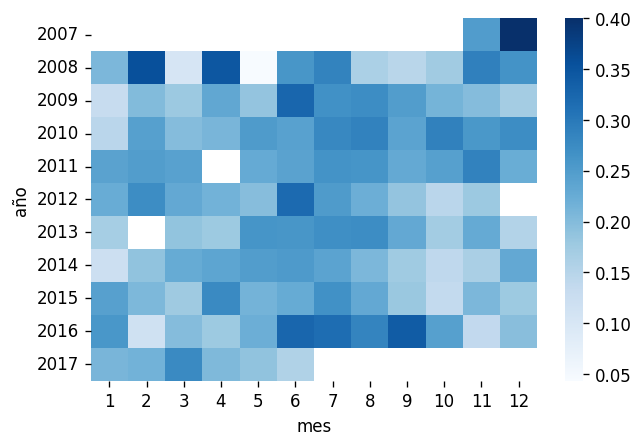

In [384]:
mes_anio = ((df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si'].groupby([df['dia'].dt.month, df['dia'].dt.year]).size())/(df.groupby([df['dia'].dt.month, df['dia'].dt.year]).size())).rename_axis(['mes','año']).to_frame()
mes_anio.columns = ['llovieron_hamburguesas_al_dia_siguiente']
mes_anio = mes_anio.reset_index(level=[0,1])
sns.heatmap(pd.pivot_table(mes_anio, index='año', columns='mes', values='llovieron_hamburguesas_al_dia_siguiente'), cmap='Blues')


In [381]:
pd.pivot_table(mes_anio, index='año', columns='mes', values='llovieron_hamburguesas_al_dia_siguiente')

mes,1,2,3,4,5,6,7,8,9,10,11,12
año,,,,,,,,,,,,
2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,0.400000
2008,0.206897,0.355556,0.104167,0.346939,0.043478,0.260000,0.286458,0.162304,0.146739,0.173469,0.290640,0.263793
2009,0.130356,0.201621,0.179304,0.232704,0.185880,0.325279,0.266427,0.272398,0.248634,0.212654,0.199456,0.171353
2010,0.146341,0.245000,0.199119,0.209410,0.252220,0.242135,0.280145,0.288256,0.238532,0.289358,0.257373,0.272405
2011,0.240072,0.248509,0.242315,NaN,0.228212,0.240775,0.263927,0.261775,0.229705,0.245383,0.287570,0.224215
2012,0.224932,0.272038,0.231441,0.215631,0.197851,0.319483,0.252244,0.221005,0.186504,0.145488,0.179652,NaN
2013,0.167563,NaN,0.187396,0.177226,0.260796,0.260533,0.269608,0.272189,0.231239,0.172384,0.228422,0.153976
2014,0.122792,0.188487,0.226562,0.236427,0.249353,0.253654,0.239295,0.207641,0.175022,0.140454,0.164218,0.230638
2015,0.243359,0.205349,0.176370,0.276465,0.214410,0.226514,0.267301,0.231092,0.180403,0.136667,0.207713,0.177966
